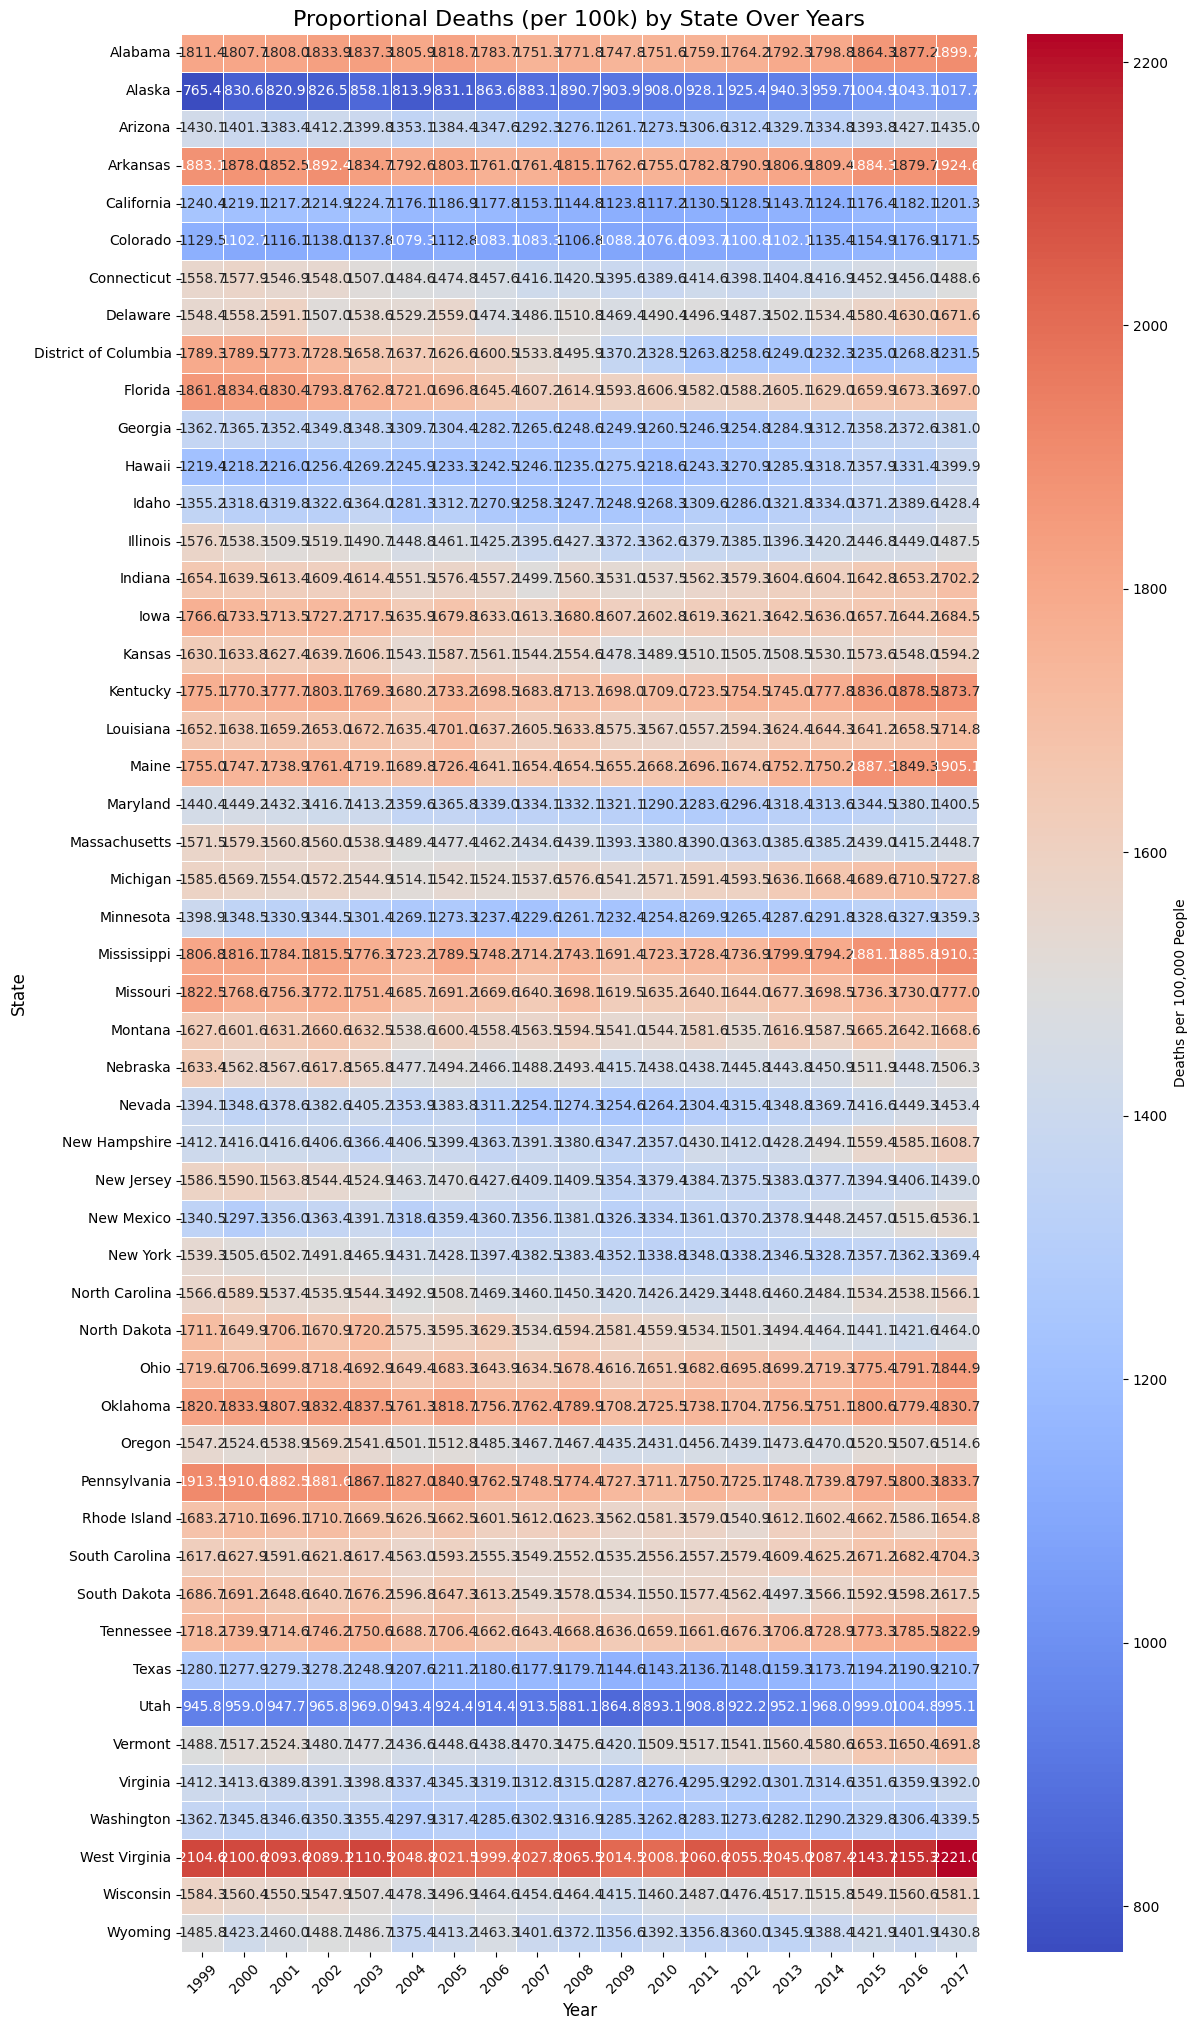

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
# import ace_tools as tools  # For displaying the dataframe

# Load dataset
df = pd.read_csv('../data/processed/US_Deaths_Populations.csv', sep=',')

# Aggregate deaths by State and Year
state_year_deaths = df.groupby(["State", "Year"])["Deaths"].sum().unstack()

# Filter out the row where State is "United States" for death count
state_year_deaths_filtered = state_year_deaths.loc[state_year_deaths.index != "United States"]

# Add population data for each state and year
population_data = df.groupby(["State", "Year"])["Population"].mean().unstack()

# Filter out the row where State is "United States" for population
population_data_filtered = population_data.loc[state_year_deaths.index != "United States"]

# Calculate proportional deaths per 100k people
proportional_data = (state_year_deaths_filtered / population_data_filtered) * 100000

# Visualize the proportional deaths
plt.figure(figsize=(12, len(proportional_data) * 0.4))
sns.heatmap(
    proportional_data,
    cmap="coolwarm",
    linewidths=0.5,
    annot=True,
    fmt=".1f",  # Display values as one decimal point
    cbar_kws={"label": "Deaths per 100,000 People"},
)

plt.title("Proportional Deaths (per 100k) by State Over Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


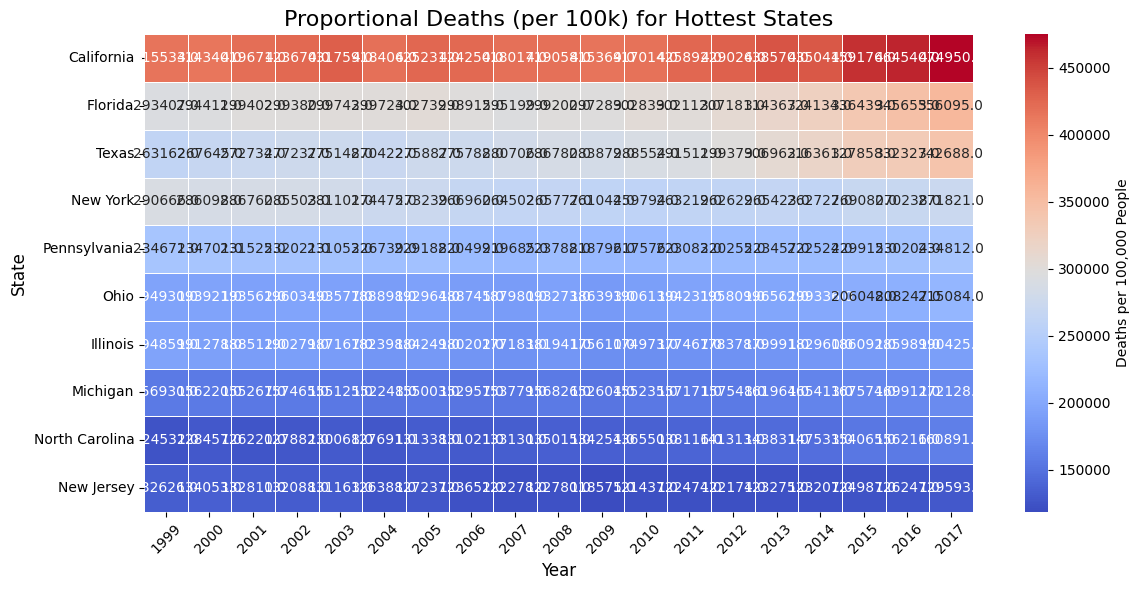

In [12]:
# Identify hottest states (top 10 by total deaths)
hottest_states = state_year_deaths_filtered.sum(axis=1).nlargest(10).index

# Filter proportional data for hottest states
proportional_data_hottest = state_year_deaths.loc[hottest_states]


# Visualize the heatmap for hottest states
plt.figure(figsize=(12, len(proportional_data_hottest) * 0.6))
sns.heatmap(
    proportional_data_hottest,
    cmap="coolwarm",
    linewidths=0.5,
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Deaths per 100,000 People"},
)

plt.title("Proportional Deaths (per 100k) for Hottest States", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

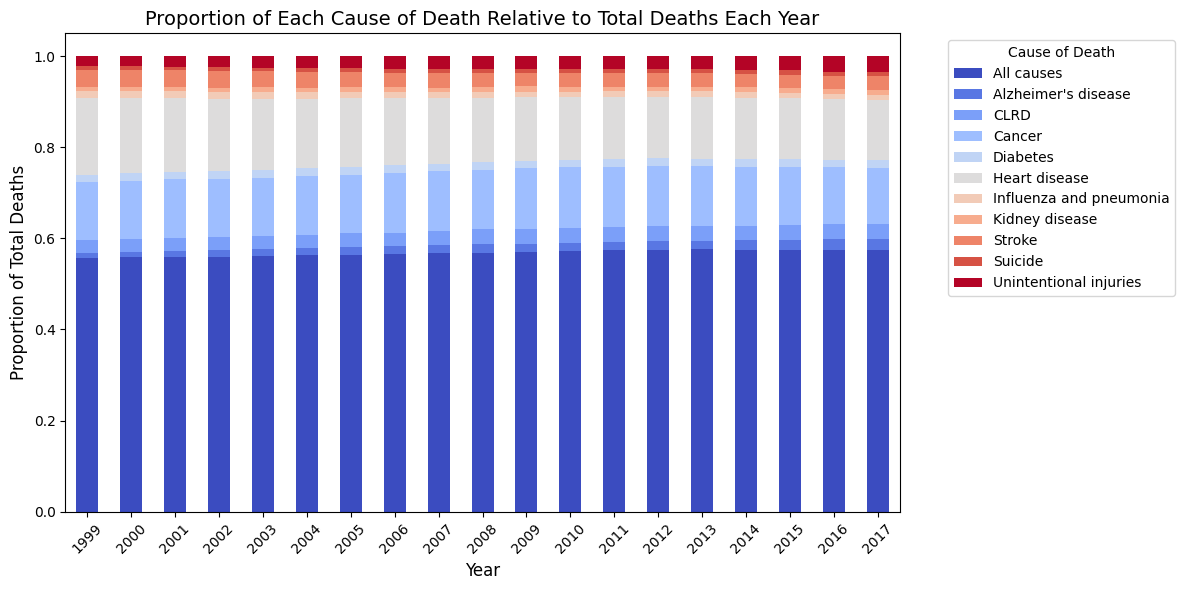

In [16]:
# Aggregate total deaths for each year (across all causes)
df_filtered = df[df["State"] != "United States"]
total_deaths_per_year = df_filtered.groupby("Year")["Deaths"].sum()

# Aggregate deaths by cause and year
cause_death_per_year = df_filtered.groupby(["Year", "Cause Name"])["Deaths"].sum().unstack()

# Calculate proportion (divide each cause by total deaths in that year)
cause_death_proportion = cause_death_per_year.div(total_deaths_per_year, axis=0)

# Display the proportion dataset
# tools.display_dataframe_to_user(name="Cause of Death Proportions", dataframe=cause_death_proportion)

plt.figure(figsize=(12, 6))
cause_death_proportion.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")

# Customize plot
plt.title("Proportion of Each Cause of Death Relative to Total Deaths Each Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Proportion of Total Deaths", fontsize=12)
plt.legend(title="Cause of Death", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

Index(['All causes', 'Alzheimer's disease', 'CLRD', 'Cancer', 'Diabetes',
       'Heart disease', 'Influenza and pneumonia', 'Kidney disease', 'Stroke',
       'Suicide', 'Unintentional injuries'],
      dtype='object', name='Cause Name')
Heart Disease Trend (slope): -0.002063084382540834
Cancer Trend (slope): -8.753941961433059e-05


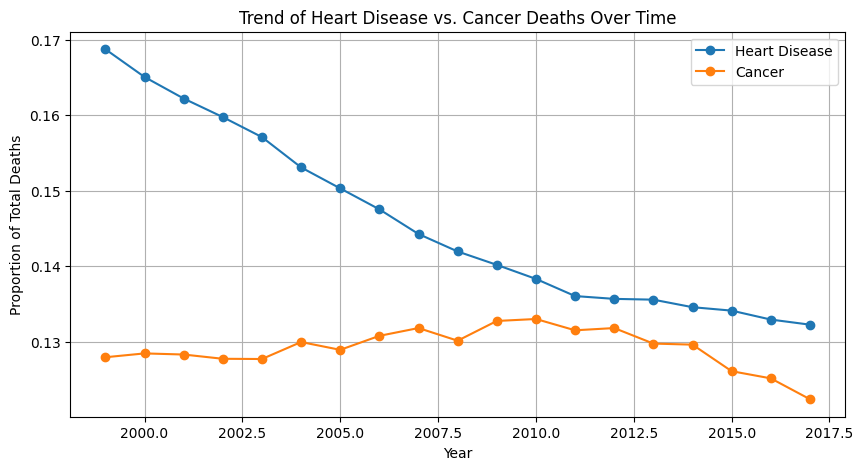

In [24]:
# From the graph I can see heart disease is decreasing while cancer is increasing
# Confirm the trend
from scipy.stats import linregress

print(cause_death_proportion.columns)

years = cause_death_proportion.index.astype(int)
heart_disease_trend = linregress(years, cause_death_proportion["Heart disease"])
cancer_trend = linregress(years, cause_death_proportion["Cancer"])

print("Heart Disease Trend (slope):", heart_disease_trend.slope)
print("Cancer Trend (slope):", cancer_trend.slope)

plt.figure(figsize=(10, 5))
plt.plot(cause_death_proportion.index, cause_death_proportion["Heart disease"], marker='o', label="Heart Disease")
plt.plot(cause_death_proportion.index, cause_death_proportion["Cancer"], marker='o', label="Cancer")

plt.title("Trend of Heart Disease vs. Cancer Deaths Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion of Total Deaths")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# TODO: identify which state contributes to positive trend in cancer

23:23:40 - cmdstanpy - INFO - Chain [1] start processing
23:23:40 - cmdstanpy - INFO - Chain [1] done processing
/home/qinyaomou/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


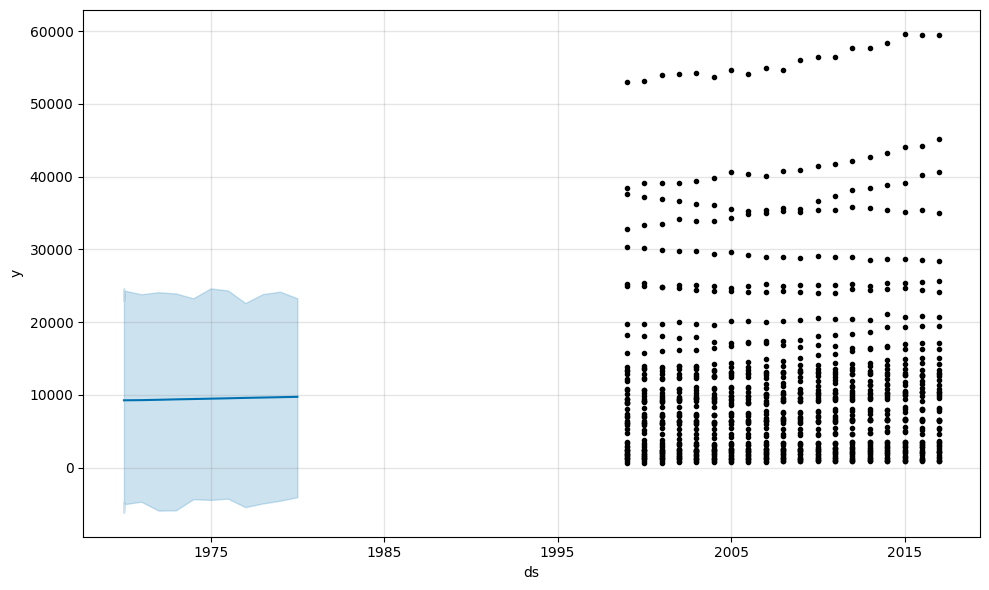

In [ ]:
from prophet import Prophet

# Predict for cancer
df_cancer = df_filtered[df_filtered["Cause Name"] == "Cancer"][["Year", "Deaths"]].rename(columns={"Year": "ds", "Deaths": "y"})

# Train model
model = Prophet()
model.fit(df_cancer)

# Predict future years
future = model.make_future_dataframe(periods=10, freq="Y")
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()